In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

import sklearn
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
data.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [4]:
data['label'] = data['label'].astype('string')
data['iamge_id'] = data['image_id'].astype('string')

data.head()

image_id label        iamge_id
0  1000015157.jpg     0  1000015157.jpg
1  1000201771.jpg     3  1000201771.jpg
2   100042118.jpg     1   100042118.jpg
3  1000723321.jpg     1  1000723321.jpg
4  1000812911.jpg     3  1000812911.jpg

In [5]:
def zoom_images(tensor):
    tensor = tf.image.central_crop(tensor, 0.80)
    return tensor

2022-02-18 14:05:18.994882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 14:05:19.120021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 14:05:19.121272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 14:05:19.124488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(320, 320, 3)


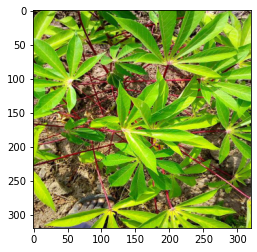

In [6]:
for image in os.listdir('../input/cassava-leaf-disease-classification/train_images')[4:5]:
    i = plt.imread(os.path.join('../input/cassava-leaf-disease-classification/train_images', image)) / 255.0
    i = tf.image.resize(i, (400, 400))
    print(zoom_images(i).shape)
    plt.imshow(zoom_images(i))

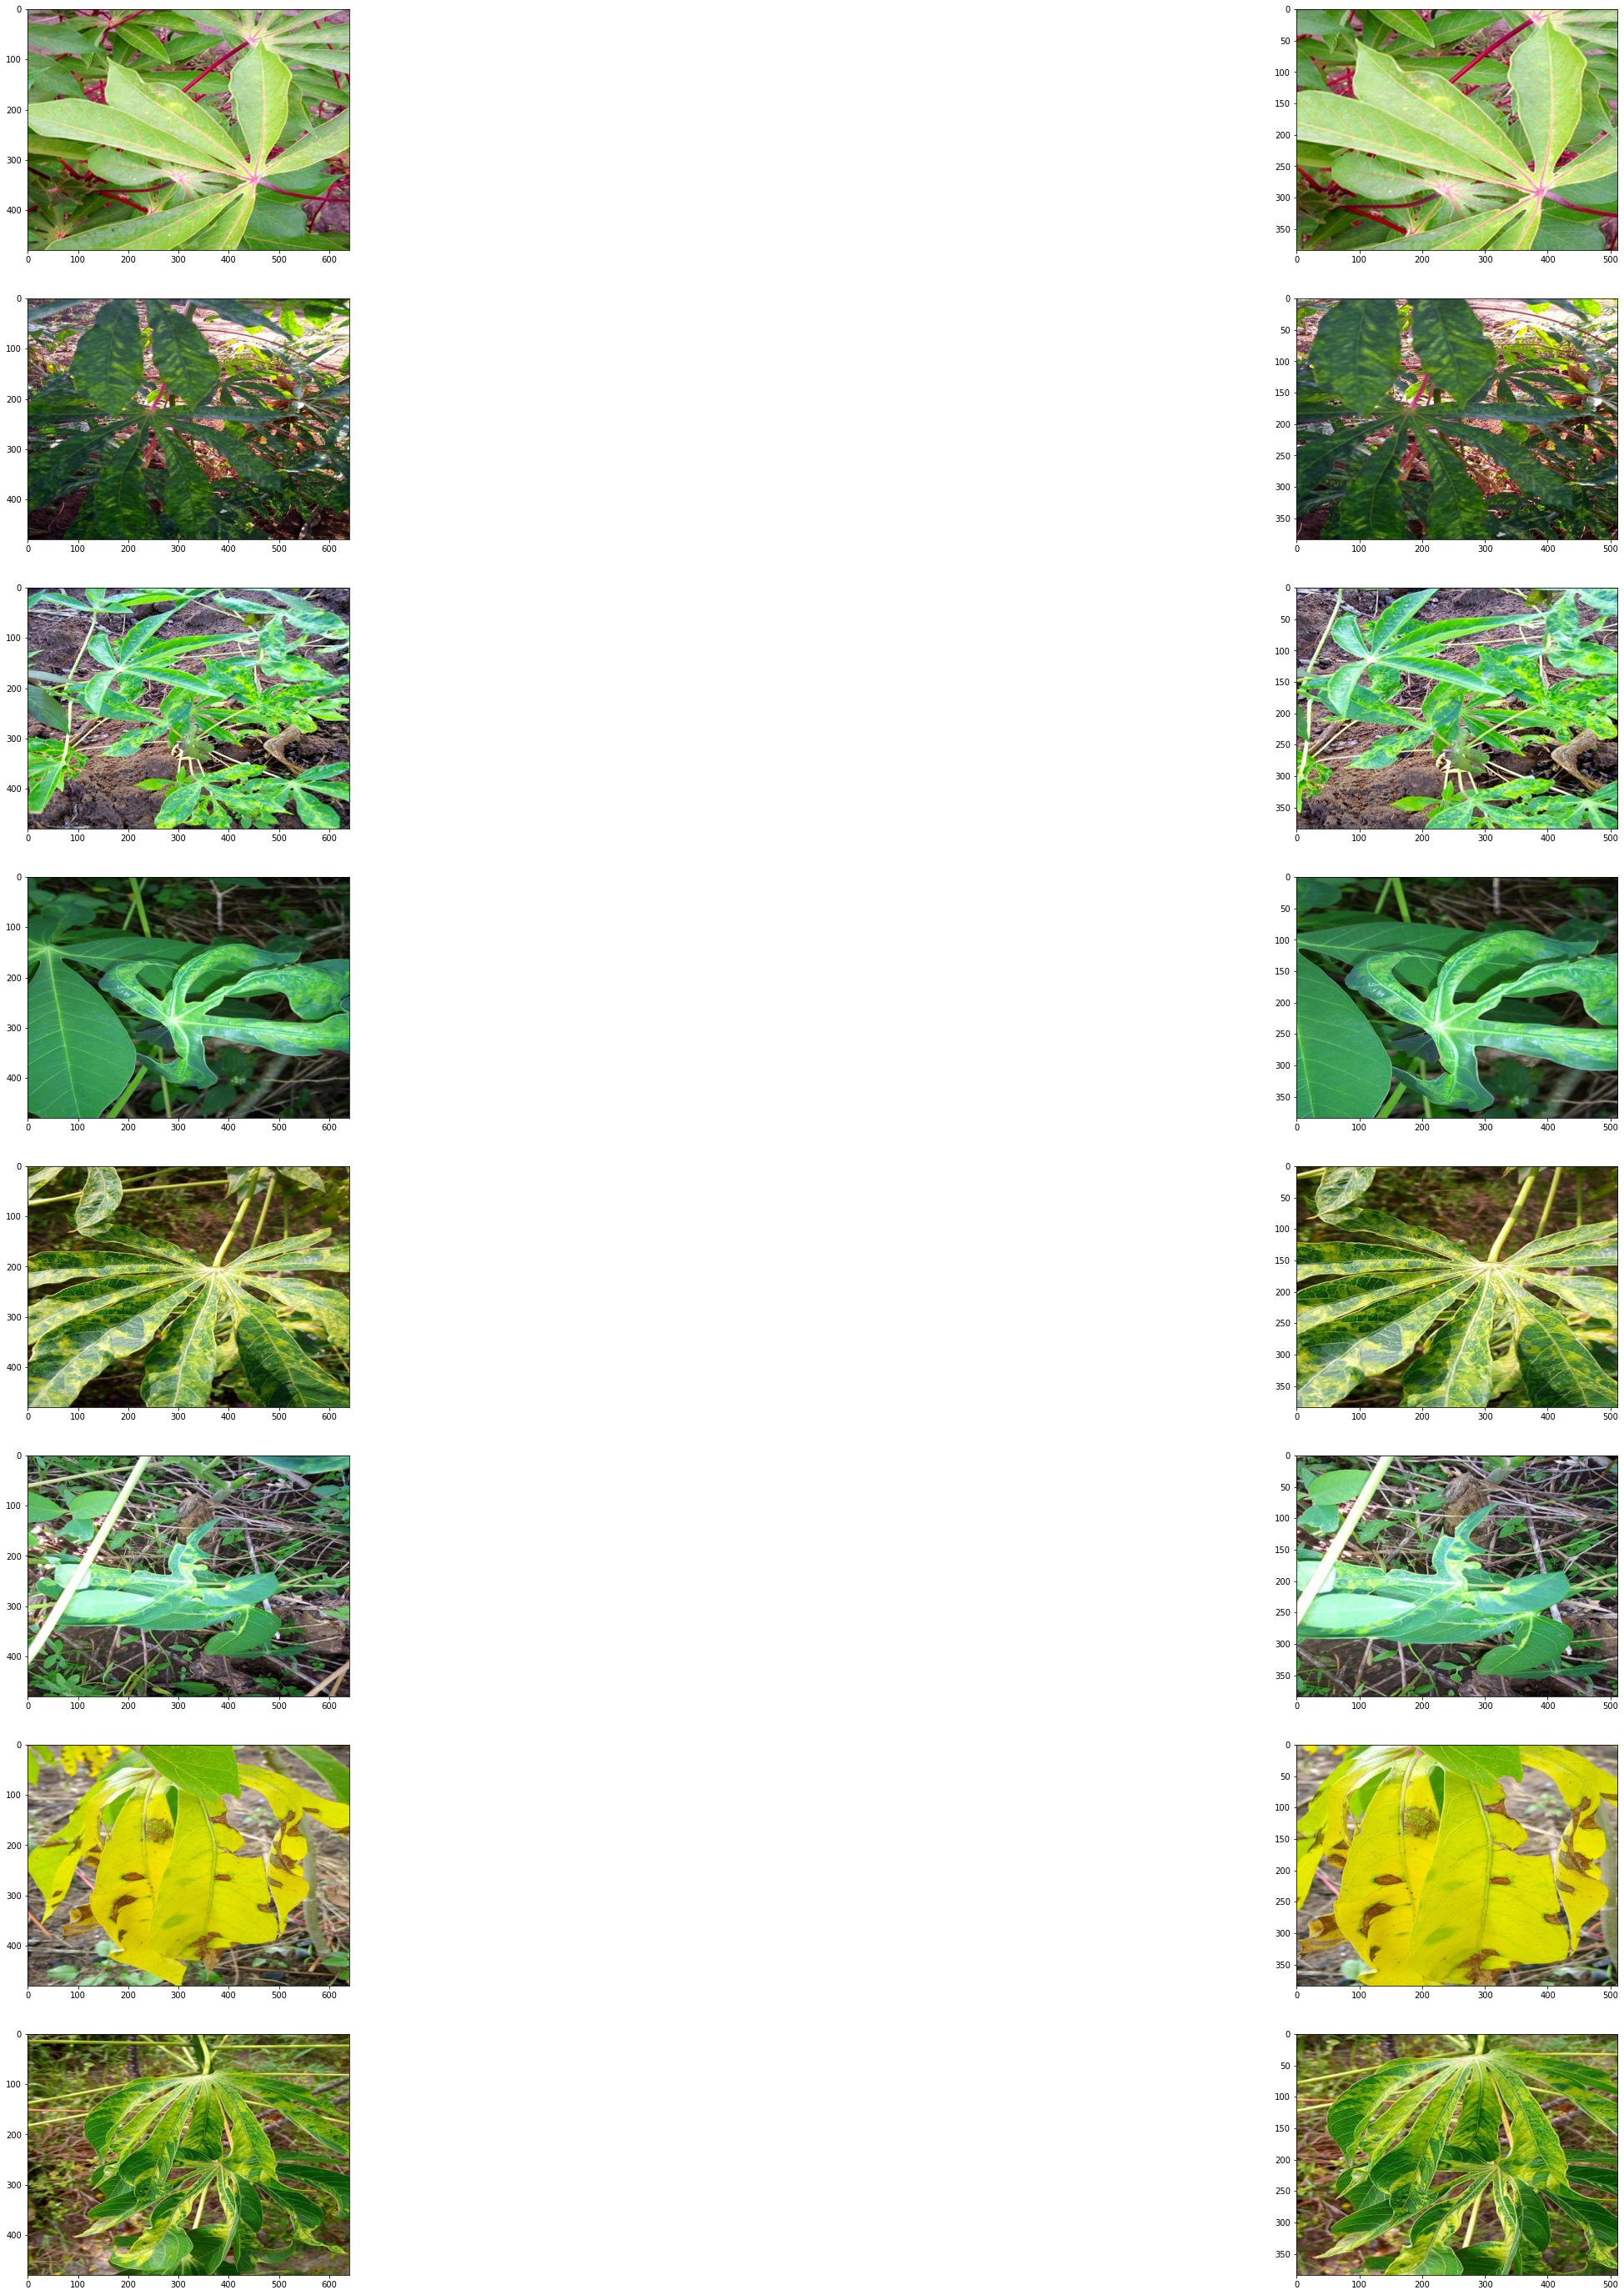

In [7]:
random_indexes = np.random.randint(0, 2000, 8)
__dir = os.listdir('../input/cassava-leaf-disease-classification/train_images')
li = [__dir[i] for i in random_indexes]
fig, axes = plt.subplots(8, 2, figsize=(50, 50))
count = 0
for k in range(8):
    img = plt.imread('../input/cassava-leaf-disease-classification/train_images/' + li[count]) / 255.0
    for j in range(2):
        axes[k][j].imshow(img)
        img = zoom_images(img)
        axes[k][j].imshow(img)
    count += 1

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(data[:int(len(data)*0.8)], x_col='image_id', y_col='label',
                                                    directory='../input/cassava-leaf-disease-classification/train_images', 
                                                    batch_size=256, class_mode='categorical', validate_filenames=False, 
                                                    target_size=(400, 400), preprocessing_function=zoom_images)

Found 17117 non-validated image filenames belonging to 5 classes.


In [9]:
validation_datagen = ImageDataGenerator(rescale=1./255.)

validation_generator = validation_datagen.flow_from_dataframe(data[int(len(data)*0.8):], x_col='image_id', y_col='label', 
                                                              directory='../input/cassava-leaf-disease-classification/train_images', 
                                                              batch_size=256, class_mode='categorical', validate_filenames=False, 
                                                              target_size=(400, 400), preprocessing_function=zoom_images)

Found 4280 non-validated image filenames belonging to 5 classes.


In [10]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
def build_model(pre_trained_model):
    
    for layer in pre_trained_model.layers:
        layer.trainable=False
    
    
    
    x = pre_trained_model.outputs[0]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[pre_trained_model.inputs], outputs=[outputs], name='test_model')
    return model

model = build_model(model)

In [12]:
model.summary()

Model: "test_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 160, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 160, 160, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 160, 160, 32) 0           bn_Conv1[0][0]                   
_________________________________________________________________________________________

In [13]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='recall', patience=2, mode='max', restore_best_weights=True, verbose=1
)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=METRICS)

In [16]:
history = model.fit(train_generator, epochs=10, callbacks=[early_stopping], validation_data=validation_generator)

2022-02-18 14:05:36.806065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-18 14:05:48.532699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


67/67 [==============================] - 463s 7s/step - loss: 0.8596 - tp: 10066.0000 - fp: 2587.0000 - tn: 65881.0000 - fn: 7051.0000 - accuracy: 0.8874 - precision: 0.7955 - recall: 0.5881 - auc: 0.9069 - prc: 0.7606 - val_loss: 0.7047 - val_tp: 2889.0000 - val_fp: 707.0000 - val_tn: 16413.0000 - val_fn: 1391.0000 - val_accuracy: 0.9020 - val_precision: 0.8034 - val_recall: 0.6750 - val_auc: 0.9381 - val_prc: 0.8333
Epoch 2/10
67/67 [==============================] - 305s 5s/step - loss: 0.6647 - tp: 11722.0000 - fp: 2449.0000 - tn: 66019.0000 - fn: 5395.0000 - accuracy: 0.9083 - precision: 0.8272 - recall: 0.6848 - auc: 0.9442 - prc: 0.8473 - val_loss: 0.6447 - val_tp: 2973.0000 - val_fp: 585.0000 - val_tn: 16535.0000 - val_fn: 1307.0000 - val_accuracy: 0.9116 - val_precision: 0.8356 - val_recall: 0.6946 - val_auc: 0.9477 - val_prc: 0.8578
Epoch 3/10
67/67 [==============================] - 302s 5s/step - loss: 0.6258 - tp: 12063.0000 - fp: 2331.0000 - tn: 66137.0000 - fn: 5054.0000

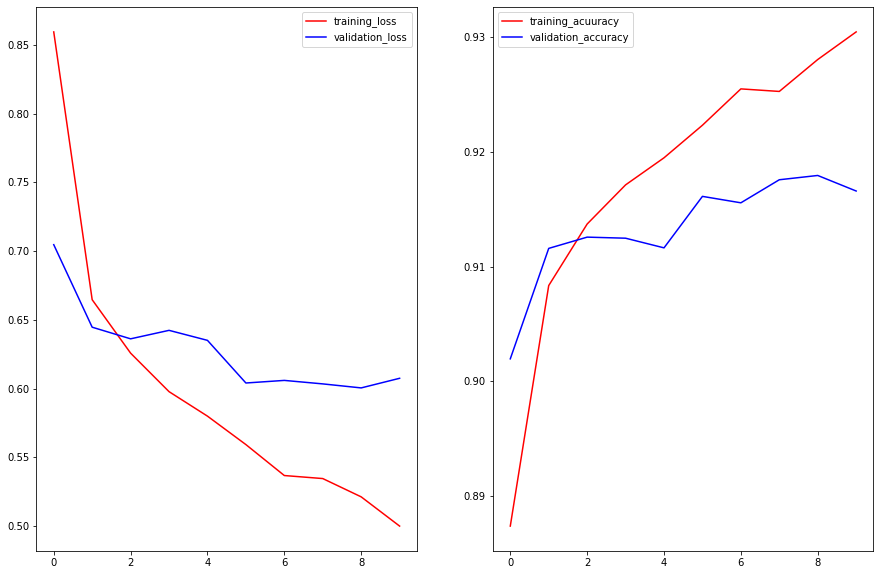

In [17]:
epochs = np.arange(len(history.history['loss']))
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].plot(epochs, history.history['loss'], color='r', label='training_loss')
axes[0].plot(epochs, history.history['val_loss'], color='b', label='validation_loss')
axes[0].legend()

axes[1].plot(epochs, history.history['accuracy'], color='r', label='training_acuuracy')
axes[1].plot(epochs, history.history['val_accuracy'], color='b', label='validation_accuracy')
axes[1].legend()

plt.show()

In [19]:
data_test = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

image_id  label
0  2216849948.jpg      4

In [49]:
def final_predict(test_img, model):
    test_image = plt.imread(test_img) / 255.0
    test_image = tf.image.resize(test_image, (400, 400))
    test_image = zoom_images(test_image)
    test_image = tf.expand_dims(test_image, 0)
    prediction = np.argmax(model.predict(test_image))
    pred_df = pd.DataFrame({"image_id": ['2216849948.jpg'], "label": [prediction]})
    
    return pred_df

prediction_df = final_predict('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg', model)


image_id  label
0  2216849948.jpg      4

In [50]:
prediction_df.to_csv('Final_Submission.csv')